# Ajuste de picos de dados DRX com Python
#### Traduzido e adaptado por Caio Valente a partir do [artigo original](https://chrisostrouchov.com/post/peak_fit_xrd_python/) de Chris Ostrouchov

<img src="images/xrd-fitting-xrd-complex-components.png" alt="Gráfico de DRX para PP" title="Polipropileno - PP"/>

## Introdução
Espectros de difração de raios-x (DRX) são combinações de curvas gaussianas, lorentzianas e de voigt. Existem muitos *softwares* comerciais e *open-source* que podem fazer a deconvolução destas curvas a partir dos espectros. Exemplos destes são **Origin Pro Peak Fitting**, **IGOR Pro**, **GSAS**, entre outros. No entanto, todos esses sofrem de um problema: eles obscurecem a matemática relativamente simples por trás dos panos. Utilizando as bibliotecas de Python **numpy** e **scipy** pode-se criar um *software* de ajuste de picos tão bem-sucedido quanto. Depois podemos usar o excelente pacote **lmfit** que automatiza as partes tediosas de programar o *software* de ajuste. Primeiro, vamos instalar e importar todas as bibliotecas e pacotes que precisamos.

### Instalação da biblioteca **lmfit**

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install lmfit

### Importando bibliotecas
> - os: para ler e escrever arquivos (integração com o Windows)
> - math: funções matemáticas
> - numpy: ferramentas de computação científica (vetores/matrizes n-dimensionais, álgebra linear, transformadas, etc)
> - pandas: ferramentas de tratamento e análise de dados
> - matplotlib.pyplot: ferramentas para plotar gráficos
> - scipy: ecossistema que engloba numpy, pandas, matplotlib, etc. São módulos voltados para matemática, ciência e engenharia. Precisamos só dos módulos optimize e signal

In [2]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal

from lmfit import models

# ignore used to produce images for blog
image_dir = "images"
def plot_to_blog(fig, figure_name):
    filename = os.path.expanduser(f'{image_dir}/{figure_name}')
    fig.savefig(filename)
    return filename

>  A função <font color=blue>plot_to_blog</font>() está sendo definida para salvar os gráficos plotados ao longo do texto, na pasta `images`.

## Funções Gaussianas, Lorentzianas e de Voigt
O processo de ajuste de curvas gaussianas, lorentzianas e de voigt pode ser escrito como uma otimização não-linear, onde tomamos a soma das funções para reproduzir os dados. Este processo de otimização será demonstrado abaixo para a distribuição de Gauss. A função gaussiana é também conhecida como a distribuição normal. Na figura abaixo, mostra-se uma gaussiana com amplitude 1, média 0 e variância 1.

$$f(x;A,\mu,\sigma) = \frac{A}{\sigma\sqrt{2\pi}} e^{[-(x-\mu)^2 /2\sigma^2]} $$

'images/xrd-fitting-gaussian.png'

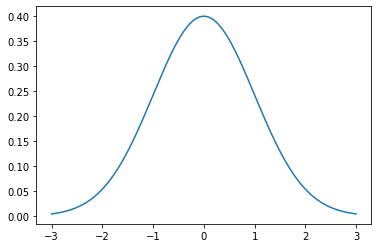

In [3]:
def g(x, A, μ, σ):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
ax.plot(x, g(x, 1, 0, 1))
plot_to_blog(fig, 'xrd-fitting-gaussian.png')

> **Observação sobre o código:** a função <font color=blue>g</font>() é definida como uma função que recebe x e retorna o valor de acordo com a função gaussiana, com os parâmetros A, $\mu$ e $\sigma$ também passados a ela. A linha `x = np.linspace(-3, 3, 1000)` cria uma sequência de -3 até 3, com 1000 valores e atribui essa lista de valores à variável `x`. Depois, a linha `ax.plot(x, g(x,1,0,1))` plota o gráfico, utilizando `x` no eixo das abscissas e `g(x,1,0,1)` nas ordenadas. Por fim, `plot_to_blog(fig, 'xrd-fitting-gaussian.png')` salva a imagem na pasta `images`, no mesmo diretório que o programa está sendo executado.

## Otimização
Algo muito importante para o ajuste destas curvas é encontrar os mínimos do espectro. Isso pode ser feito com a biblioteca `scipy` que importamos anteriormente. O método **scipy.optimize.minimize** é bastante útil e conta com diversos otimizadores. Usaremos apenas o otimizador padrão para estas demonstrações. Suponha que temos uma função desconhecida plotada abaixo.

'images/xrd-fitting-unknown.png'

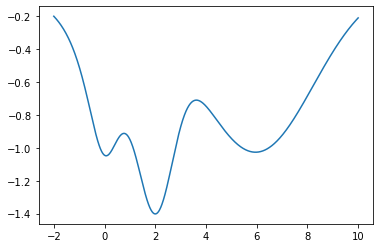

In [4]:
def f(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/(x**2 + 1)

x = np.linspace(-2, 10, 1000)
fig, ax = plt.subplots()
ax.plot(x, -f(x))
plot_to_blog(fig, 'xrd-fitting-unknown.png')

> **OBS**: Usamos a mesma lógica que para plotar a curva de Gauss, mas desta vez estamos usando uma função <font color=blue>f</font>(x) arbitrária. Esta função só será usada para testar a função de otimização que encontra o mínimo global.

Agora usamos `scipy.optimize.minimize` para achar o mínimo global da função

In [5]:
print('|{:>16}|{:>16}|{:>16}|'.format('initial','iterations','minimum'))
initial_guess = -0.5
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')

initial_guess = -2
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')

initial_guess = 9
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')

|         initial|      iterations|         minimum|
|            -0.5|               5|           0.064|
|            -2.0|               4|           2.001|
|            +9.0|               3|           5.955|


> **OBS**: Podemos acessar o número de iterações utilizado pela função através do atributo `nit`, ou seja, o número de iterações de `result` é `result.nit`. Do mesmo modo, podemos acessar o mínimo calculado através de `x[0]`. Assim, `result.x[0]` nos dá o mínimo da função arbitrária <font color = blue>f</font>(x).

Veja que, dependendo do chute inicial `initial_guess`, a função `optimize.minimize` retorna um resultado diferente. Isso acontece para qualquer problema de otimização global. Essas rotinas de otimização **não** garantem que encontraram o mínimo global. Este é um problema comum em ajustes de curvas com espectros de difração de raios-x, onde muitos mínimos locais fazem a rotina ficar travada neles, e as curvas não são ajustadas corretamente. Por isso é extremamente importante ter bons chutes iniciais. 

Vamos usar esta otimização para ajustar uma gaussiana com algum ruído. Veja o gráfico abaixo, que contém os dados que queremos ajustar

'images/xrd-fitting-gaussian-noise.png'

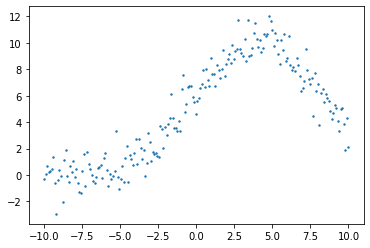

In [6]:
A = 100.0 # intensity
μ = 4.0  # mean
σ = 4.0 # peak width
n = 200
x = np.linspace(-10, 10, n)
y = g(x, A, μ, σ) + np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(x, y, s=2)
plot_to_blog(fig, 'xrd-fitting-gaussian-noise.png')

> **OBS**: Desta vez a resposta y é dada pela função gaussiana <font color = 'blue'>g</font> mais um ruído aleatório dado por `np.random.randn(n)` (uma função que retorna um número randomizado em torno de zero) 

### Ajuste

Agora podemos utilizar a otimização para tentar estimar quais são os parâmetros da gaussiana. Nosso algoritmo precisa de um valor que dê uma medida da melhora. Usaremos a função de erro quadrático médio, a qual iremos minimizar com a função de otimização. Chamaremos esta função de *custo*, uma vez que ela deve ser minimizada. Seu valor pode ser calculado com a equação:
$$ MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i-\hat{Y}_i)^2 $$
Onde $Y_i$ e $\hat{Y}_i$ representam, respectivamente, os valores do modelo e os valores observados. Quanto melhor o ajuste, mais próximos de zero serão os valores de $MSE$.

steps 20 0.9277770598520325
amplitude: 102.154 mean: 4.049 sigma: 3.973


'images/xrd-fitting-gaussian-noise.png'

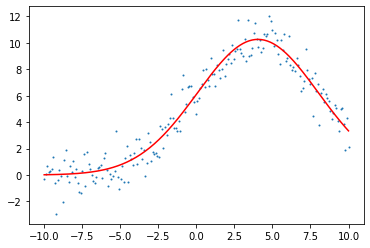

In [7]:
def cost(parameters):
    a, b, c = parameters
    # y has been calculated in previous snippet
    return np.sum(np.power(g(x, a, b, c) - y, 2)) / len(x)

result = optimize.minimize(cost, [0, 0, 1])
print('steps', result.nit, result.fun)
print(f'amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
ax.plot(x, g(x,*result.x[:3]), color='red')
plot_to_blog(fig, 'xrd-fitting-gaussian-noise.png')

> **OBS**: Veja que estamos usando o chute inicial dos parâmetros como [0,0,1]. Ou seja, o chute é amplitude = 0, a média = 0 e variância = 1. Quando tivermos mais curvas convolutas, será importante estimá-las próximas da realidade, para não cairmos nos problemas mostrados anteriormente de mínimo local/global. O método `optimize.minimize()` recebe a função que deve ser minimizada e retorna um resultado `result` que contém as informações do ajuste do modelo. O que precisamos é dos parâmetros amplitude (`result.x[0]`), média (`result.x[1]`) e variância (`result.x[2]`).

Pelo gráfico, podemos ver que o ajuste ficou ótimo. Vejamos como funciona para duas gaussianas.

'images/xrd-fitting-two-gaussian-noise.png'

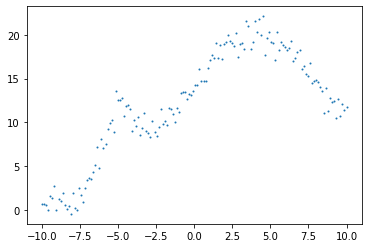

In [8]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 150
x = np.linspace(-10, 10, n)
y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise.png')

> **OBS**: Estes pontos são a soma de duas gaussianas, mais um ruído randômico.

steps 67 0.955198698452109
g_0: amplitude: 254.117 mean: 4.063 sigma: 5.081
g_1: amplitude: 20.129 mean: -4.973 sigma: 1.038


'images/xrd-fitting-two-gaussian-noise-opt.png'

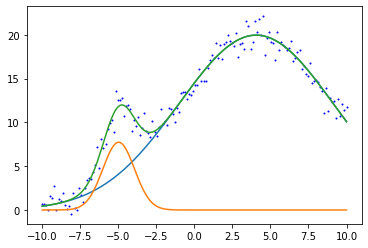

In [9]:
def cost(parameters):
    g_0 = parameters[:3]
    g_1 = parameters[3:6]
    return np.sum(np.power(g(x, *g_0) + g(x, *g_1) - y, 2)) / len(x)

initial_guess = [1, 0, 1, -1, 0, 1]
result = optimize.minimize(cost, initial_guess)
print('steps', result.nit, result.fun)
print(f'g_0: amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
print(f'g_1: amplitude: {result.x[3]:3.3f} mean: {result.x[4]:3.3f} sigma: {result.x[5]:3.3f}')

fig, ax = plt.subplots()
ax.scatter(x, y, s=1,color='blue')
ax.plot(x, g(x, *result.x[:3]))
ax.plot(x, g(x, *result.x[3:6]))
ax.plot(x, g(x, *result.x[:3]) + g(x, *result.x[3:6]))
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-opt.png')

### Usando o pacote lmfit

Estes resultados são suficientes para tentarmos utilizar esta metodologia para dados reais de DRX. Porém, o método de construção da otimização se mostra tedioso, para dizer o mínimo. Usaremos então o pacote projetado justamente para isso: `lmfit`. Este pacote constrói o modelo que representa seus dados adicionando várias funções juntas. No nosso caso, serão gaussianas, lorentzianas e de voigt. No entanto, o lmfit é bem mais flexível que isso, podendo utilizar várias [funções embutidas](https://lmfit.github.io/lmfit-py/builtin_models.html), além de funções arbitrárias escritas em Python.

'images/xrd-fitting-two-gaussian-noise-lmfit.png'

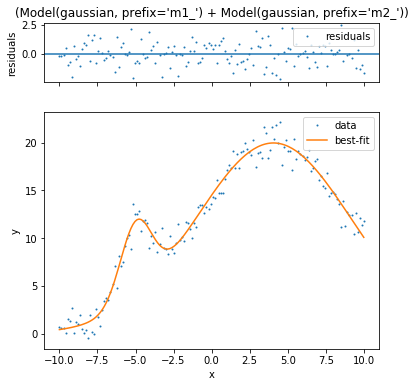

In [10]:
model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=2, sigma=1)
params_2 = model_2.make_params(center=-2, sigma=1)
params = params_1.update(params_2)

output = model.fit(y, params, x=x)
fig, gridspec = output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-lmfit.png')

> **OBS**: aqui são gerados dois modelos com a função `models.GaussianModel()`. Depois, utiliza-se o método `.make_params()` em cada modelo para passar os chutes iniciais de centro e variância de cada pico. Os modelos e parâmetros são unidos nas variáveis `model` e `params` e, em seguida, é usado o método `.fit` no modelo, passando os pontos x e y (gerados anteriormente, que representam os dados experimentais), para gerar um `output`. Esta variável carrega as informações da otimização feita pela biblioteca `lmfit`, e possui um método interno `.plot()` que plota o gráfico dos dados e função ajustada, bem como o gráfico dos resíduos (importante para ver se o ajuste foi bem feito, os resíduos devem estar aleatoriamente dispersos em torno de zero).

Repare que `lmfit` facilita a construção do modelo. Você simplesmente soma os modelos e ajusta os chutes iniciais para cada um através de `make_params`. Se você desejar, é possível colocar limites e outras restrições com `set_param_hint`. Usando os conhecimentos da área de DRX podemos simplificar a criação destes modelos. O código abaixo vai ajustar os chutes iniciais, colocar limites nos valores de variáveis, e usar um dicionário Python (`spec`) como entrada dos modelos.

In [11]:
def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

> **OBS**: Aqui o autor criou uma função <font color = 'blue'>generate model</font>() para facilitar a vida da construção dos modelos. Basicamente ela recebe um dicionário Python que contém os dados experimentais e os modelos que se deseja utilizar, e retorna o modelo e os parâmetros, prontos para serem usados no método `.fit` como fizemos anteriormente.

In [12]:
spec = {
    'x': x,
    'y': y,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

> **OBS**: Este é o esqueleto da variável `spec` que usaremos para dizer para o programa quais são nossos dados (`'x'` são os valores de 2$\theta$ e `'y'` são os valores de intensidade) e quais/quantas são as curvas que devem ser ajustadas aos dados. Neste caso, `'x'` recebe os valores `x` que geramos anteriormente e `'y'` recebe os valores de `y` que também geramos anteriormente. Além disso, nossos dados são duas curvas tipo gaussianas, então colocamos `'model'` como uma lista (entre colchetes `[]`) de dicionários (entre chaves `{}`) com os dois modelos que vamos usar. Ou seja, se fossem 3 curvas, adicionaríamos mais uma linha `{'type': 'GaussianModel'}` dentro dos colchetes.

'images/xrd-fitting-two-gaussian-noise-lmfit-spec.png'

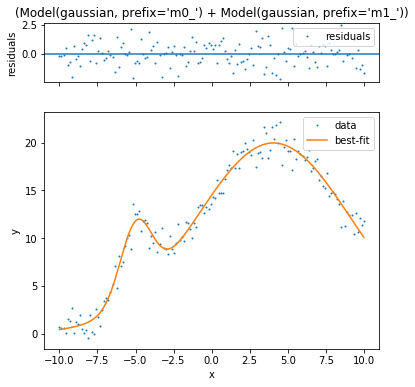

In [13]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-lmfit-spec.png')

> **OBS**: Esta parte é idêntica à que usamos sem `lmfit`, com exceção do uso da função `generate_model()` que definimos anteriormente.

## Utilizando dados reais
Finalmente, podemos utilizar dados reais de DRX. Os dados são de polipropileno e apresentam um pouco de ruído.

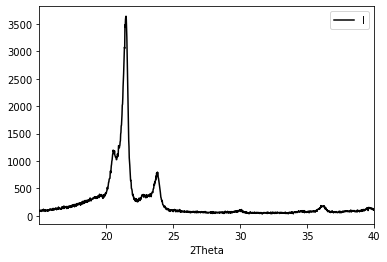

In [14]:
df = pd.read_csv('PEAD.csv', delim_whitespace=True, skiprows=32,
                 names=['2Theta','I'])
df.plot(kind = 'line', x='2Theta',y='I',color='black')

> **OBS**: Aqui estou utilizando a biblioteca `pandas` para importar os dados do polipropileno obtido no Centro Multiusuário de Caracterização de Materiais da UTFPR. Como o autor original não disponibilizou os dados dele pois ainda não foram publicados, tive que usar dados do nosso grupo de pesquisa. A variável `df` recebe um dataframe, que contém todos os pontos do experimento como numa tabela Excel. Acessamos as colunas através da sintaxe `df['Nome da Coluna']`. Ou seja, agora os valores `x` serão `df['2Theta']` e `y` serão `df['I']`.

É tedioso encontrar todos os picos manualmente, então vamos escrever uma função que nos ajude a atribuir valores iniciais para os chutes baseados nos picos. Essa rotina utiliza o método `find_peaks_cwt` do módulo Scipy. Ele se mostra superior a muitos outros algoritmos de encontrar picos que existem.

In [15]:
def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

> **OBS**: Esta parte do programa define a função <font color = 'blue'>update_spec_from_peaks</font>(), que recebe a variável `spec` (que já definimos antes) e os índices dos modelos (uma lista de índices referentes a quantos e quais picos ela deve encontrar) e retorna a posição dos picos, além de atualizar a variável `spec` com os parâmetros calculados a partir da posição, altura e largura dos picos.

'images/xrd-fitting-xrd-peaks.png'

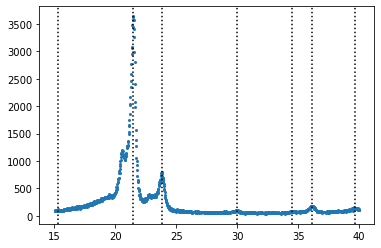

In [57]:
spec = {
    'x': df['2Theta'].values,
    'y': df['I'].values,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2, 3, 4, 5], peak_widths=(15,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

plot_to_blog(fig, 'xrd-fitting-xrd-peaks.png')

> **OBS**: Aqui criamos um `spec` com 10 modelos, e encontramos 12 picos marcados com linhas pontilhadas. Esses picos foram achados pela função `update_spec_from_peaks`, que também alterou a `spec` para incluir os parâmetros de cada pico.

'images/xrd-fitting-xrd-total.png'

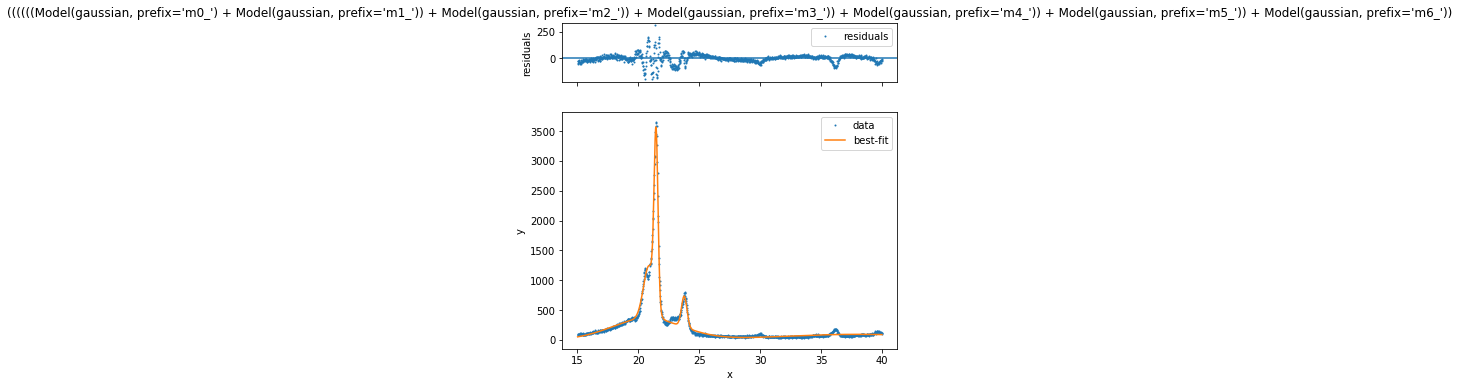

In [58]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})
plot_to_blog(fig, 'xrd-fitting-xrd-total.png')

> **OBS**: Utilizamos novamente a função `generate_model`, com o `spec` atualizado para gerar um `output` do nosso modelo ajustado. Exatamente como antes, mas com os dados reais. Note que os resíduos são altos onde o modelo não está muito bem ajustado.

7


'images/xrd-fitting-xrd-components.png'

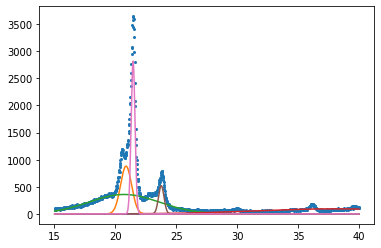

In [59]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

plot_to_blog(fig, 'xrd-fitting-xrd-components.png')

> **OBS**: Utilizamos o método `.eval_components()` no `output` para extrair as curvas componentes do nosso modelo. No caso, são dez curvas (assim como o número de modelos que colocamos em `spec`). Usamos um loop `for` para plotar todas elas.

Os picos em 20 > 2$\theta$ > 22.5 não foram deconvoluídos corretamente. Podemos usar apenas esta parte dos dados.

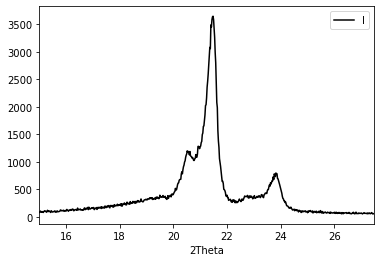

In [33]:
ndf = df[(df['2Theta']<27.5)]
ndf.plot(kind = 'line', x='2Theta',y='I',color='black')

> **OBS**: Estou utilizando um filtro da biblioteca `pandas` para selecionar os dados em que 2$\theta$ está entre 20 e 25 graus. Faremos o mesmo processo, mas para quatro curvas.

'images/xrd-fitting-xrd-peaks.png'

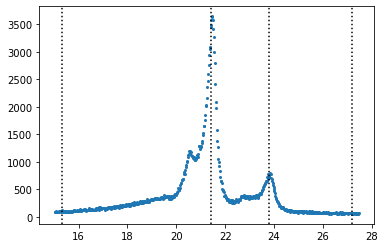

In [38]:
spec = {
    'x': ndf['2Theta'].values,
    'y': ndf['I'].values,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2], peak_widths=(15,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

plot_to_blog(fig, 'xrd-fitting-xrd-peaks.png')

'images/xrd-fitting-xrd-total.png'

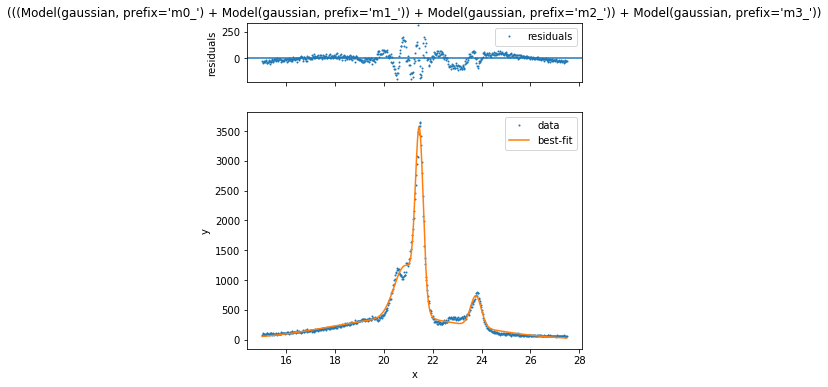

In [39]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})
plot_to_blog(fig, 'xrd-fitting-xrd-total.png')

4


'images/xrd-fitting-xrd-components.png'

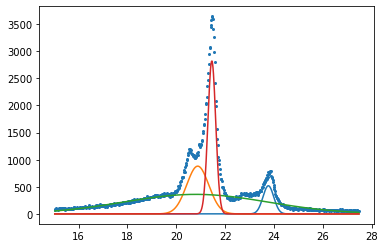

In [40]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

plot_to_blog(fig, 'xrd-fitting-xrd-components.png')

## Saída de dados calculados
Para retirar os parâmetros ótimos calculados, precisamos de uma nova função que receba `spec` e `output` e nos mostre os valores de centro, tipo de modelo, amplitude, $\sigma$ e $\gamma$

In [41]:
def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma']
    }
    best_values = output.best_values
    print('center   model            amplitude     sigma     gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')

> **OBS**: Essa função, `print_best_values()` extrai os dados do `output` usando o atributo `.best_values`. É uma forma de mostrar os resultados de forma mais legível, mas poderia ser substituído por um `print(output.best_values)`

In [60]:
print_best_values(spec,output)

center   model            amplitude     sigma     gamma
[37.241] GaussianModel   :  113.795,    0.000
[20.878] GaussianModel   :  998.920,    0.452
[20.714] GaussianModel   : 2600.284,    2.893
[38.016] GaussianModel   : 1516.156,    6.453
[33.101] GaussianModel   :    0.003,    0.226
[23.768] GaussianModel   :  291.895,    0.224
[21.454] GaussianModel   : 1130.981,    0.160


15 a 27.5
```
center   model            amplitude     sigma     gamma
[23.769] GaussianModel   :  286.859,    0.221
[20.876] GaussianModel   :  998.243,    0.452
[20.793] GaussianModel   : 2676.117,    2.962
[21.454] GaussianModel   : 1132.196,    0.160
{'m3_amplitude': 1132.1958076401318,
 'm3_center': 21.453502726951783,
 'm3_sigma': 0.16011134858487028,
 'm2_amplitude': 2676.1168837039886,
 'm2_center': 20.792721004593695,
 'm2_sigma': 2.9624929647409126,
 'm1_amplitude': 998.2434621000716,
 'm1_center': 20.876060906513537,
 'm1_sigma': 0.45212825336461737,
 'm0_amplitude': 286.85860687620624,
 'm0_center': 23.76918709784634,
 'm0_sigma': 0.22054936551646934}
```

In [61]:
output.best_values

{'m6_amplitude': 1130.9814277164976,
 'm6_center': 21.45362643503011,
 'm6_sigma': 0.16003635143765763,
 'm5_amplitude': 291.8952690681911,
 'm5_center': 23.76795637901558,
 'm5_sigma': 0.22352325069013296,
 'm4_amplitude': 0.0030051334715336386,
 'm4_center': 33.1008007232525,
 'm4_sigma': 0.2261850543331683,
 'm3_amplitude': 1516.1561566608352,
 'm3_center': 38.01589734782941,
 'm3_sigma': 6.4533757803140475,
 'm2_amplitude': 2600.2843865483374,
 'm2_center': 20.714389962063393,
 'm2_sigma': 2.8931086014187155,
 'm1_amplitude': 998.9197832693037,
 'm1_center': 20.878339872489324,
 'm1_sigma': 0.45238954180287516,
 'm0_amplitude': 113.79477767917791,
 'm0_center': 37.24072641981557,
 'm0_sigma': 2.9704714807194605e-05}

In [67]:
a = (286.859+998.243+1132.196)
a

2417.298

In [66]:
b = (2676.117)
b

2676.117

In [68]:
a/(a+b)

0.4745927830345652

### Selecionando chutes iniciais manualmente
Uma `spec` mais complexa pode ser usada para definir exatamente a localidade de cada pico a ser estudado. A definição com todos os parâmetros possíveis está abaixo. Neste caso não estamos usando `find_peaks_cwt` para encontrar os picos, mas colocando eles manualmente dentro dos modelos.

'images/xrd-fitting-xrd-data-complex-lmfit.png'

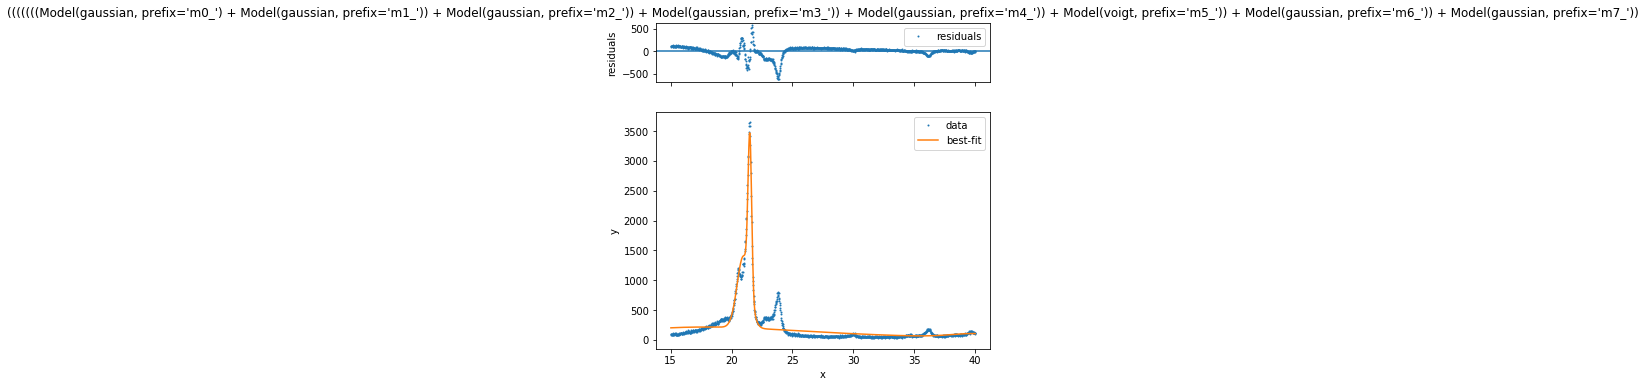

In [23]:
spec = {
    'x': df['2Theta'].values,
    'y': df['I'].values,
    'model': [
        {
            'type': 'GaussianModel',
            'params': {'center': 16.02, 'height': 743, 'sigma': 0.1},
            'help': {'center': {'min': 15.9, 'max': 16.1}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 16.78, 'height': 1008, 'sigma': 0.1},
            'help': {'center': {'min': 16.7, 'max': 16.9}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 18.39, 'height': 726, 'sigma': 0.1},
            'help': {'center': {'min': 18.3, 'max': 18.5}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 21, 'height': 721, 'sigma': 0.1},
            'help': {'center': {'min': 20.8, 'max': 21.2}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 21.7, 'height': 684, 'sigma': 0.1},
            'help': {'center': {'min': 21.5, 'max': 21.9}}
        },
        {'type': 'VoigtModel', 'params': {'center': 18, 'height': 240, 'sigma': 0.05, 'gamma': 0.15}},
        {
            'type': 'GaussianModel',
            'params': {'center': 25.5, 'height': 206, 'sigma': 0.1},
            'help': {'center': {'min': 25, 'max': 26}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 28.3, 'height': 164, 'sigma': 0.1},
            'help': {'center': {'min': 27, 'max': 29}}
        },
        #{'type': 'GaussianModel', 'help': {'center': {'max': 39.2}}},
        #{'type': 'GaussianModel'},
        #{'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-xrd-data-complex-lmfit.png')

8


'images/xrd-fitting-xrd-complex-components.png'

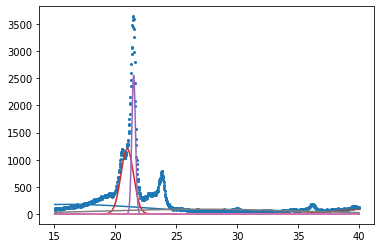

In [24]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

plot_to_blog(fig, 'xrd-fitting-xrd-complex-components.png')

In [26]:
print_best_values(spec,output)

center   model            amplitude     sigma     gamma
[16.100] GaussianModel   : 2966.298,    6.721
[16.813] GaussianModel   :    0.000,    0.392
[18.312] GaussianModel   :  274.288,    0.000
[20.974] GaussianModel   : 1548.936,    0.515
[21.500] GaussianModel   :  964.258,    0.151
[40.000] VoigtModel      :  569.536,    1.437,    1.437
[25.142] GaussianModel   :    0.000,    0.020
[27.000] GaussianModel   : 1745.493,    8.044


In [27]:
print(output.best_values)

{'m7_amplitude': 1745.4930643696637, 'm7_center': 27.000000000000007, 'm7_sigma': 8.043779721907397, 'm6_amplitude': 1.0025247921818803e-06, 'm6_center': 25.14244659269141, 'm6_sigma': 0.019845507479416366, 'm5_amplitude': 569.5360863030694, 'm5_center': 39.99983770682746, 'm5_sigma': 1.4368785717033787, 'm5_gamma': 1.4368785717033787, 'm4_amplitude': 964.2575504582894, 'm4_center': 21.500000000000718, 'm4_sigma': 0.1505907096686623, 'm3_amplitude': 1548.9362313536512, 'm3_center': 20.973779072842305, 'm3_sigma': 0.5145965116928506, 'm2_amplitude': 274.2879158154829, 'm2_center': 18.312305477207204, 'm2_sigma': 0.00030518439343004506, 'm1_amplitude': 1.0012957559757396e-06, 'm1_center': 16.81277433406933, 'm1_sigma': 0.3921302669948681, 'm0_amplitude': 2966.298432665319, 'm0_center': 16.099936803571715, 'm0_sigma': 6.720745541244659}
